In [77]:
#import required libraries — we do need the models, flatten, dense, input layers 
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
import cv2

In [78]:
# Path for train, validation and test datasets
train_path = '/kaggle/input/ourdatasetddd/train'
valid_path = '/kaggle/input/ourdatasetddd/test'
test_path = '/kaggle/input/ourdatasetddd/val'
IMAGE_SIZE = [224, 224] #Default image size for VGG16
folders = glob('/kaggle/input/ourdatasetddd/train/*') #Get number of classes
# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
#Through flow_from_directory - we create an array of images that can be used for training. 
training_set = train_datagen.flow_from_directory(
'/kaggle/input/ourdatasetddd/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('/kaggle/input/ourdatasetddd/val',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/ourdatasetddd/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3559 images belonging to 4 classes.
Found 540 images belonging to 4 classes.
Found 588 images belonging to 4 classes.


In [79]:
 #vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(len(folders), activation='softmax')(x) # We have 4 classes, and so, the prediction is being done on len(folders) - 4 classes
#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [80]:
#Compile the model 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model.fit(training_set, validation_data=validation_set, epochs=30, batch_size=32)

Epoch 1/30
56/56 [==============================] - 53s 936ms/step - loss: 0.6606 - accuracy: 0.7665 - val_loss: 0.1126 - val_accuracy: 0.9611
Epoch 2/30
56/56 [==============================] - 49s 866ms/step - loss: 0.1184 - accuracy: 0.9663 - val_loss: 0.0949 - val_accuracy: 0.9593
Epoch 3/30
56/56 [==============================] - 48s 864ms/step - loss: 0.0864 - accuracy: 0.9789 - val_loss: 0.1169 - val_accuracy: 0.9537
Epoch 4/30
56/56 [==============================] - 49s 874ms/step - loss: 0.0708 - accuracy: 0.9823 - val_loss: 0.1035 - val_accuracy: 0.9593
Epoch 5/30
56/56 [==============================] - 49s 873ms/step - loss: 0.0644 - accuracy: 0.9798 - val_loss: 0.0966 - val_accuracy: 0.9611
Epoch 6/30
56/56 [==============================] - 49s 876ms/step - loss: 0.0539 - accuracy: 0.9865 - val_loss: 0.0775 - val_accuracy: 0.9630
Epoch 7/30
56/56 [==============================] - 48s 862ms/step - loss: 0.0486 - accuracy: 0.9860 - val_loss: 0.0585 - val_accuracy: 0.9648

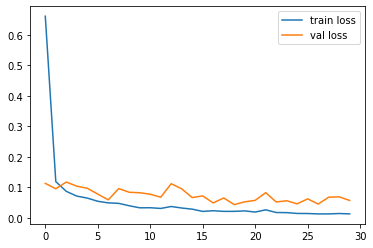

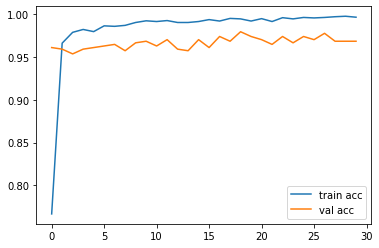

In [81]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
 
 # accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [82]:
from tensorflow.keras.models import load_model
model.save('VGG16.h5')
model.save('VGG16.model')

Prediction

In [83]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 224
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("VGG16.h5")

In [84]:
prediction = model.predict([prepare("/kaggle/input/ourdatasetddd/train/no_yawn/1000.jpg")])
np.argmax(prediction)

2

In [85]:
prediction = model.predict([prepare("/kaggle/input/ourdatasetddd/train/yawn/1000.jpg")])
np.argmax(prediction)

3

In [86]:
prediction = model.predict([prepare("/kaggle/input/ourdatasetddd/train/Closed/_160.jpg")])
np.argmax(prediction)

0

In [87]:
prediction = model.predict([prepare("/kaggle/input/ourdatasetddd/train/Open/_160.jpg")])
np.argmax(prediction)

1